In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision

from torch.utils.data import DataLoader



In [8]:
#loading the dataset
data = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

#creating a dataloader 
dataloader = DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True
)

#defining the model
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    

model = DigitClassifier()
print(model)

        



DigitClassifier(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=10, bias=True)
    (8): LogSoftmax(dim=1)
  )
)


In [29]:
#training the model
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#first we will only have a loss function and no regularization
num_epochs = 5

losses_without_reg = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    losses_without_reg.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

    accuracy = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    print(f"Accuracy after epoch {epoch+1}: {100 * accuracy / total}%")
    

Epoch 1, Loss: 0.06063770769245382
Accuracy after epoch 1: 98.79833333333333%
Epoch 2, Loss: 0.04353713865029757
Accuracy after epoch 2: 99.14333333333333%
Epoch 3, Loss: 0.0356118723679744
Accuracy after epoch 3: 99.23833333333333%
Epoch 4, Loss: 0.028806676219075622
Accuracy after epoch 4: 99.24333333333334%
Epoch 5, Loss: 0.024665548739483085
Accuracy after epoch 5: 99.46%


In [30]:
#now we will add regularization to the loss function and then compare the results with the previous one

import torch.nn.functional as F

def l2_reg(model, lambda_L2):
    l2_normalised = torch.tensor(0.)
    for i in model.parameters():
        l2_normalised += torch.norm(i)**2
    return lambda_L2 * l2_normalised

def new_loss_function(outputs, labels, model, lambda_L2):
    ce_loss = loss_function(outputs, labels)
    l2_loss = l2_reg(model, lambda_L2)
    return ce_loss + l2_loss




new_num_epochs = 5
lambda_L2 = 0.001
losses_with_reg = []
for epoch in range(new_num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        output = model(images)
        loss = new_loss_function(output, labels, model, lambda_L2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    losses_with_reg.append(avg_loss)
    print(f"Epoch {epoch+1} with L2 regularization, Loss: {avg_loss}")
    
    accuracy = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    print(f"Accuracy after epoch {epoch+1} with L2 regularization: {100 * accuracy / total}%")







Epoch 1 with L2 regularization, Loss: 0.29788862353067663
Accuracy after epoch 1 with L2 regularization: 98.68833333333333%
Epoch 2 with L2 regularization, Loss: 0.223993453199167
Accuracy after epoch 2 with L2 regularization: 97.80333333333333%
Epoch 3 with L2 regularization, Loss: 0.21771661827622701
Accuracy after epoch 3 with L2 regularization: 98.33166666666666%
Epoch 4 with L2 regularization, Loss: 0.21618619024245214
Accuracy after epoch 4 with L2 regularization: 98.50166666666667%
Epoch 5 with L2 regularization, Loss: 0.213433731752418
Accuracy after epoch 5 with L2 regularization: 98.08166666666666%


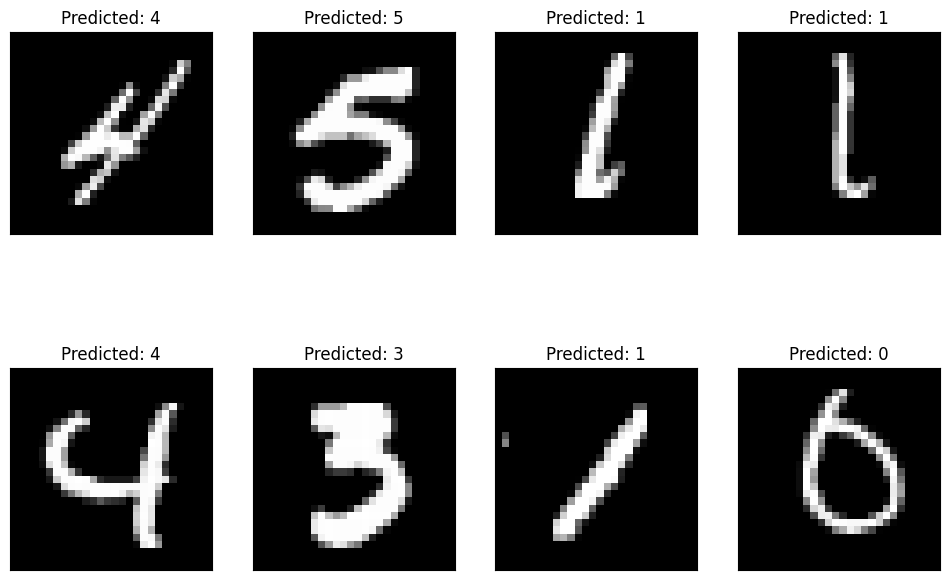

In [31]:
import matplotlib.pyplot as plt
import numpy as np

#visualizing some predictions
dataiter = iter(dataloader)
images, labels = next(dataiter)
output = model(images)
_, predicted = torch.max(output, 1)
fig = plt.figure(figsize=(12, 8))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].numpy().squeeze(), cmap='gray')
    ax.set_title(f"Predicted: {predicted[idx].item()}")
plt.show()



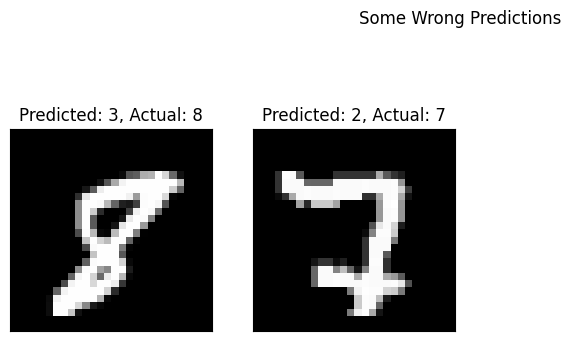

In [32]:
#plotting some wrong predictions
data_iter = iter(dataloader)
Wrong_img = []
images, labels = next(data_iter)
output = model(images)
_, predicted = torch.max(output, 1)
wrong_count = 0
fig = plt.figure(figsize=(12, 8))
for i in range(len(labels)):
    if predicted[i] != labels[i] and wrong_count < 8:
        ax = fig.add_subplot(2, 4, wrong_count+1, xticks=[], yticks=[])
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
        Wrong_img.append(images[i])
        wrong_count += 1
plt.suptitle("Some Wrong Predictions")       
plt.show()

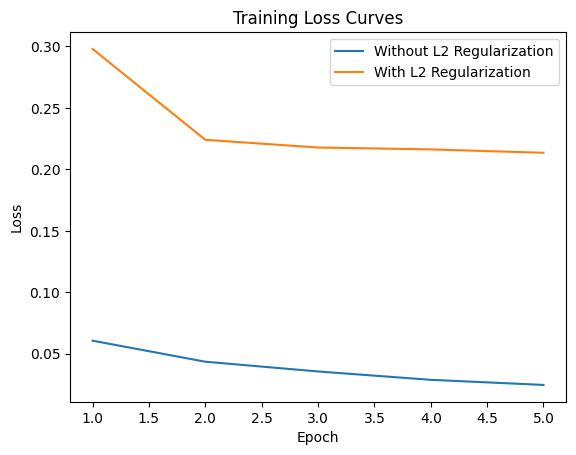

In [33]:
#plotting the loss curves
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(1, len(losses_without_reg)+1), losses_without_reg, label='Without L2 Regularization')
plt.plot(range(1, len(losses_with_reg)+1), losses_with_reg, label='With L2 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curves')
plt.show()

In [41]:
# L1 Regularization Training
model_l1 = DigitClassifier()
optimizer_l1 = optim.Adam(model_l1.parameters(), lr=0.001)

def l1_reg(model, lambda_L1):
    l1_normalised = torch.tensor(0., device=next(model.parameters()).device)
    for param in model.parameters():
        l1_normalised += torch.norm(param, 1)
    return lambda_L1 * l1_normalised

def new_loss_function_l1(outputs, labels, model, lambda_L1):
    ce_loss = loss_function(outputs, labels)
    l1_loss = l1_reg(model, lambda_L1)
    return ce_loss + l1_loss

num_epochs_l1 = 5
lambda_L1 = 0.00001
losses_l1 = []

for epoch in range(num_epochs_l1):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer_l1.zero_grad()
        output = model_l1(images)
        loss = new_loss_function_l1(output, labels, model_l1, lambda_L1)
        loss.backward()
        optimizer_l1.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    losses_l1.append(avg_loss)
    print(f"Epoch {epoch+1} with L1 regularization, Loss: {avg_loss}")

    acc = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            output = model_l1(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            acc += (predicted == labels).sum().item()
    print(f"Accuracy after epoch {epoch+1} with L1 regularization: {100 * acc / total}%")

Epoch 1 with L1 regularization, Loss: 0.35187284864469376
Accuracy after epoch 1 with L1 regularization: 96.90333333333334%
Epoch 2 with L1 regularization, Loss: 0.19749855166718142
Accuracy after epoch 2 with L1 regularization: 98.23166666666667%
Epoch 3 with L1 regularization, Loss: 0.16688856397515167
Accuracy after epoch 3 with L1 regularization: 98.41833333333334%
Epoch 4 with L1 regularization, Loss: 0.14426918674125347
Accuracy after epoch 4 with L1 regularization: 98.82%
Epoch 5 with L1 regularization, Loss: 0.1288589183757427
Accuracy after epoch 5 with L1 regularization: 98.74833333333333%


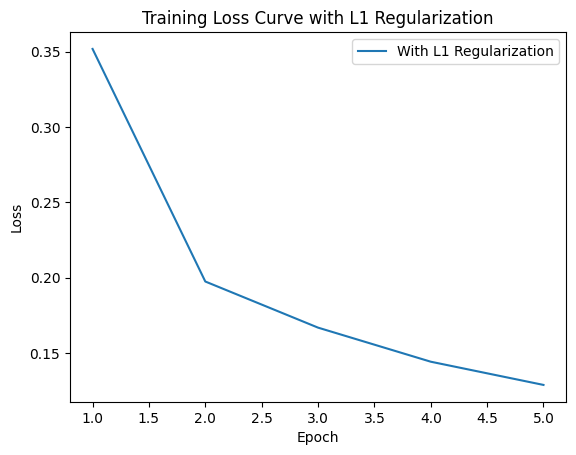

In [42]:
#plotting the loss curves for l1 regularization
import matplotlib.pyplot as plt
import numpy as np

plt.plot(
    range(1, num_epochs_l1+1),
    losses_l1,
    label='With L1 Regularization'
)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve with L1 Regularization')
plt.legend()
plt.show()


Epoch 1 with Elastic Net regularization, Loss: 0.34915799387037627
Accuracy after epoch 1 with Elastic Net regularization: 96.20666666666666%
Epoch 2 with Elastic Net regularization, Loss: 0.20148420892258698
Accuracy after epoch 2 with Elastic Net regularization: 98.06166666666667%
Epoch 3 with Elastic Net regularization, Loss: 0.16874324259505089
Accuracy after epoch 3 with Elastic Net regularization: 98.27%
Epoch 4 with Elastic Net regularization, Loss: 0.14749421127664764
Accuracy after epoch 4 with Elastic Net regularization: 98.70333333333333%
Epoch 5 with Elastic Net regularization, Loss: 0.13388770532760538
Accuracy after epoch 5 with Elastic Net regularization: 98.43833333333333%


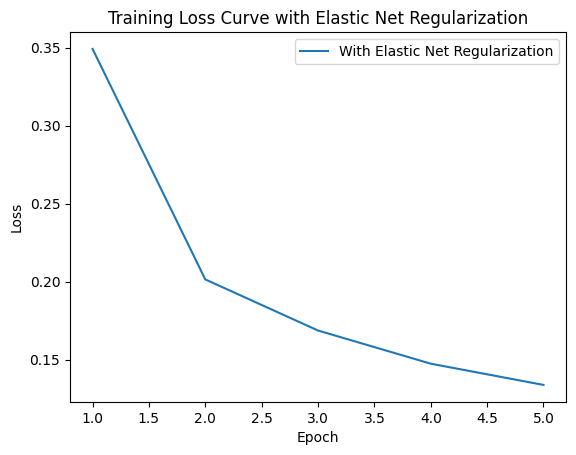

In [40]:
# Elastic Net Regularization Training
model_elastic = DigitClassifier()
optimizer_elastic = optim.Adam(model_elastic.parameters(), lr=0.001)

def elastic_net(model, lambda_1, lambda_2):
    l1_normalised = torch.tensor(0., device=next(model.parameters()).device)
    l2_normalised = torch.tensor(0., device=next(model.parameters()).device)
    for param in model.parameters():
        l1_normalised += torch.norm(param, 1)
        l2_normalised += torch.norm(param)**2
    return lambda_1 * l1_normalised + lambda_2 * l2_normalised

def new_loss_function_elastic(outputs, labels, model, lambda_1, lambda_2):
    ce_loss = loss_function(outputs, labels)
    elastic_loss = elastic_net(model, lambda_1, lambda_2)
    return ce_loss + elastic_loss

num_epochs_elastic = 5
lambda_1 = 0.00001  # Reduced regularization strength
lambda_2 = 0.00001  # Reduced regularization strength
losses_elastic = []

for epoch in range(num_epochs_elastic):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer_elastic.zero_grad()
        output = model_elastic(images)
        loss = new_loss_function_elastic(output, labels, model_elastic, lambda_1, lambda_2)
        loss.backward()
        optimizer_elastic.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    losses_elastic.append(avg_loss)
    print(f"Epoch {epoch+1} with Elastic Net regularization, Loss: {avg_loss}")

    acc = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            output = model_elastic(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            acc += (predicted == labels).sum().item()
    print(f"Accuracy after epoch {epoch+1} with Elastic Net regularization: {100 * acc / total}%")

#plotting the loss curves for elastic net regularization
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(1, num_epochs_elastic+1), losses_elastic, label='With Elastic Net Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve with Elastic Net Regularization')
plt.legend()
plt.show()

In [ ]:
#making a gif of the loss curves over epochs for different regularizations
import matplotlib.pyplot as plt
import imageio

filenames = []
num_epochs = 5
for epoch in range(num_epochs):
    plt.figure()
    plt.plot(
        range(1, epoch+2),
        losses_without_reg[:epoch+1],
        label='Without Regularization'
    )
    plt.plot(
        range(1, epoch+2),
        losses_with_reg[:epoch+1],
        label='With L2 Regularization'
    )
    plt.plot(
        range(1, epoch+2),
        losses_l1[:epoch+1],
        label='With L1 Regularization'
    )
    plt.plot(
        range(1, epoch+2),
        losses_elastic[:epoch+1],
        label='With Elastic Net Regularization'
    )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curves')
    plt.legend()
    
    filename = f'loss_curve_epoch_{epoch+1}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()



In [45]:
# Create a GIF
with imageio.get_writer(
    'loss_curves.gif',
    mode='I',
    duration=5
) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\64pul\AppData\Local\Temp\ipykernel_18552\3696504644.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
